In [1]:
cd ..

/home/wesg/research/neuron-stats


In [2]:
# autoreload
%load_ext autoreload
%autoreload 2

import os
import pickle
import argparse
import einops
import torch
import numpy as np
import pandas as pd
from transformer_lens import HookedTransformer
from summary_viewer import *
import matplotlib.pyplot as plt
import seaborn as sns
import datasets
import torch
import itertools
from utils import *
from scipy.stats import skew, kurtosis
from analysis.weights import neuron_vocab_cosine_moments
from analysis.vocab_df import *
from analysis.prediction_neurons import *
from transformer_lens.utils import gelu_fast

torch.set_grad_enabled(False)

%matplotlib inline

/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.0.6) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [3]:
def load_neuron_df(model):
    neuron_df = pd.read_csv(f'summary_data/{model}/weights/neuron_stats.csv')
    vocab_comps = torch.load(f'summary_data/{model}/weights/vocab_comps.pt')

    neuron_df['vocab_mean'] = vocab_comps['U_out']['comp_mean'].flatten().numpy()
    neuron_df['vocab_var'] = vocab_comps['U_out']['comp_var'].flatten().numpy()
    neuron_df['vocab_skew'] = vocab_comps['U_out']['comp_skew'].flatten().numpy()
    neuron_df['vocab_kurt'] = vocab_comps['U_out']['comp_kurt'].flatten().numpy()
    return neuron_df

In [4]:
neuron_df = load_neuron_df('stanford-gpt2-medium-a')

In [5]:
paper_examples = [
    (19, 1169, 'is_year', False),
    (23, 2042, 'contains_open_paren', True),
    (18, 3483, 'starts_w_space', False),
]

In [6]:
model = HookedTransformer.from_pretrained('stanford-gpt2-medium-a', device='cpu')
vocab_df = make_vocab_df(model)

ds = datasets.load_from_disk('token_datasets/gpt2/pile.test.all.512')
token_tensor = ds['tokens']
token_freqs = compute_token_dataset_statistics(vocab_df, token_tensor)
vocab_df['token_prob'] = token_freqs

Using pad_token, but it is not set yet.


Loaded pretrained model stanford-gpt2-medium-a into HookedTransformer


/home/wesg/research/neuron-stats/analysis/vocab_df.py:242: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vocab_df[feature_name] = vocab_df['token_string'].apply(feature_fn)
/home/wesg/research/neuron-stats/analysis/vocab_df.py:244: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vocab_df['unembed_norm'] = model.W_U.norm(
/home/wesg/research/neuron-stats/analysis/vocab_df.py:246: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

In [23]:
plot_df = pd.DataFrame(paper_examples, columns=['layer', 'neuron', 'feature', 'is_supression'])
comp_dict = make_composition_dict(model, plot_df, use_cos=False)

0 | layer 19 | neuron 1169


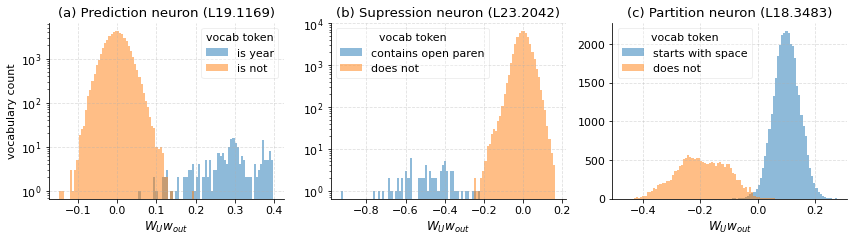

In [24]:
# set fontsize 11
plt.rcParams.update({'font.size': 11})

legend_display = {
    'is_year': ('is year', 'is not'),
    'contains_open_paren': ('contains open paren', 'does not'),
    'starts_w_space': ('starts with space', 'does not'),

}

titles = ['(a) Prediction neuron', '(b) Supression neuron', '(c) Partition neuron']
fig, axs = plt.subplots(1, 3, figsize=(12, 3.5))
for ix, (layer, neuron_ix, class_label, _) in enumerate(paper_examples):
    ax = axs[ix]
    labels = legend_display[class_label]
    comp_scores = comp_dict[layer, neuron_ix]
    bin_range = np.min(comp_scores), np.max(comp_scores)
    ax.hist(comp_scores[vocab_df[class_label]], bins=100,
	    log=ix < 2, range=bin_range, label=labels[0], alpha=0.5)
    ax.hist(comp_scores[~vocab_df[class_label]], bins=100,
	    log=ix < 2, range=bin_range, label=labels[1], alpha=0.5)
    ax.set_title(f'{titles[ix]} (L{layer}.{neuron_ix})')
    ax.legend(title='vocab token').get_frame().set_alpha(0.3)

axs[0].set_ylabel('vocabulary count')

for ax in axs:
    # turn off top and right borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('$W_Uw_{out}$')
    ax.grid(alpha=0.4, linestyle='--')
    ax.xaxis.label.set_size(12)

plt.tight_layout()

plt.savefig('figures/prediction_neuron_histograms_main.png', bbox_inches='tight')

In [12]:
models = ['stanford-gpt2-medium-a', 'stanford-gpt2-medium-b', 'stanford-gpt2-medium-c', 'stanford-gpt2-medium-d', 'stanford-gpt2-medium-e']
model_dfs = {model: load_neuron_df(model) for model in models}
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
combined_df = pd.concat(model_dfs.values(), keys=model_dfs.keys(), names=['model', 'flat_neuron'])


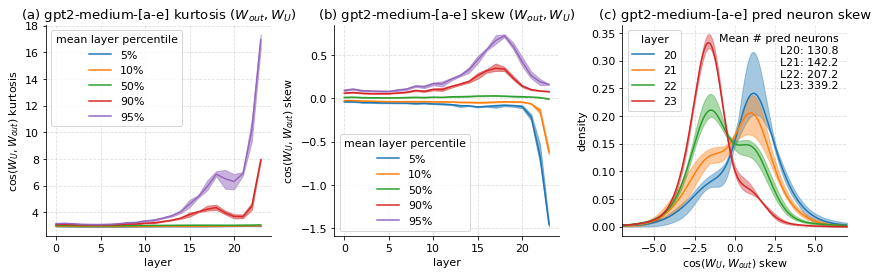

In [73]:
import matplotlib.patches as mpatches

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
metrics = ['vocab_kurt', 'vocab_skew']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
percentiles = [0.05, 0.1, 0.5, 0.9, 0.95]
for ix, metric in enumerate(metrics):
    ax = axs[ix]
    for jx, percentile in enumerate(percentiles):
        percentile_df = combined_df.groupby(['model', 'layer'])[metric].quantile(percentile).reset_index()
        percentile_median = percentile_df.groupby('layer')[metric].mean().values
        percentile_ub = percentile_df.groupby('layer')[metric].max().values
        percentile_lb = percentile_df.groupby('layer')[metric].min().values
        ax.plot(percentile_median, label=f'{int(percentile*100)}%', color=colors[jx])
        ax.fill_between(range(len(percentile_median)), percentile_lb, percentile_ub, color=colors[jx], alpha=0.5)

    ax.set_title(metric)
axs[0].legend(title='mean layer percentile')
axs[1].legend(title='mean layer percentile', loc='lower left')
# Add custom legend item
# custom_patch = mpatches.Patch(color='gray', alpha=0.3, label='max/min [a-e]')
# handles, labels = axs[0].get_legend_handles_labels()  # assuming both legends are identical
# handles.append(custom_patch)
# axs[0].legend(handles=handles, title='mean layer percentile')
# axs[1].legend(handles=handles, title='mean layer percentile', loc='lower left')

axs[0].set_xlabel('layer')
axs[1].set_xlabel('layer')
axs[0].set_ylabel('$\cos(W_U, W_{out})$ kurtosis')
axs[1].set_ylabel('$\cos(W_U, W_{out})$ skew')

axs[0].set_title('(a) gpt2-medium-[a-e] kurtosis ($W_{out}, W_U$)')
axs[1].set_title('(b) gpt2-medium-[a-e] skew ($W_{out}, W_U$)')

plot_combined_prediction_neuron_skew(combined_df, models, colors=colors, ax=axs[2])
axs[2].set_title('(c) gpt2-medium-[a-e] pred neuron skew')
axs[2].set_xlabel('$\cos(W_U, W_{out})$ skew')
axs[2].set_ylabel('density')

# custom_patch = mpatches.Patch(color='gray', alpha=0.3, label='[a-e] range')
# handles, labels = axs[2].get_legend_handles_labels()  # assuming both legends are identical
# handles.append(custom_patch)
# axs[2].legend(handles=handles, title='layer', loc='upper left')


for ax in axs:
    # turn off top and right borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(alpha=0.4, linestyle='--')

plt.tight_layout()

plt.savefig('figures/prediction_neuron_percentiles_main.png', bbox_inches='tight')

In [13]:
from analysis.prediction_neurons import *
neuron_df = model_dfs['stanford-gpt2-medium-a']

In [14]:
model = HookedTransformer.from_pretrained('stanford-gpt2-medium-a')


high_kurtosis_df = neuron_df.query('vocab_kurt > 10').reset_index()
high_var_df = neuron_df.query('vocab_var > 0.005').reset_index()

high_kurtosis_composition_dict = make_composition_dict(model, high_kurtosis_df, use_cos=False)
high_var_composition_dict = make_composition_dict(model, high_var_df, use_cos=False)
print('finished computing compositions')

Using pad_token, but it is not set yet.


Loaded pretrained model stanford-gpt2-medium-a into HookedTransformer
0 | layer 3 | neuron 63
100 | layer 16 | neuron 1380
200 | layer 17 | neuron 3011
300 | layer 18 | neuron 3053
400 | layer 19 | neuron 3022
500 | layer 20 | neuron 2113
600 | layer 21 | neuron 1102
700 | layer 21 | neuron 3828
800 | layer 22 | neuron 1693
900 | layer 22 | neuron 3475
1000 | layer 23 | neuron 937
1100 | layer 23 | neuron 2248
1200 | layer 23 | neuron 3362
0 | layer 15 | neuron 2158
finished computing compositions


In [15]:
plot_neurons = [
    ((18, 836), "is_reflexive_pronoun"),
    ((23, 2205), "is_second_person_pronoun"),
    ((23, 2330), "is_female_pronoun"),
    ((22, 73), "is_neutral_pronoun"),
    ((23, 2774), "is_male_pronoun"),
    ((20, 1601), "contains_question"),
    ((23, 2110), "is_one_digit"),
    ((21, 1920), "contains_exclamation"),
    ((23, 3803), "is_contrastive_conjuction"),
    ((22, 1693), "is_relative_pronoun"),
    ((21, 970), "contains_apostrophe"),
    ((17, 332), "is_year"),
    ((23, 2652), "contains_digit"),
    ((20, 2965), "contains_close_paren"),
    ((22, 2800), "contains_quotation"),
    ((20, 1501), "is_month"),
    ((23, 3151), "contains_semicolon"),
    ((21, 880), "contains_open_bracket"),
    ((23, 2042), "contains_open_paren"),
    ((23, 2926), "is_demonstrative_pronoun"),
    ((23, 2333), "contains_currency"),
    ((23, 1033), "contains_colon"),
    ((19, 3794), "is_state"),
    ((23, 2182), "is_possessive_pronoun"),
    ((23, 219), "contains_exclamation"),
    ((23, 2772), "starts_w_cap"),
    ((20, 13), "all_caps"),
    ((18, 3483), "start_w_no_space"),
    ((21, 593), "end_w_ed"),
    ((22, 1585), "end_w_ing"),
]
top_pred_neurons = [n for n, c in plot_neurons]
top_pred_neuron_class = [c for n, c in plot_neurons]

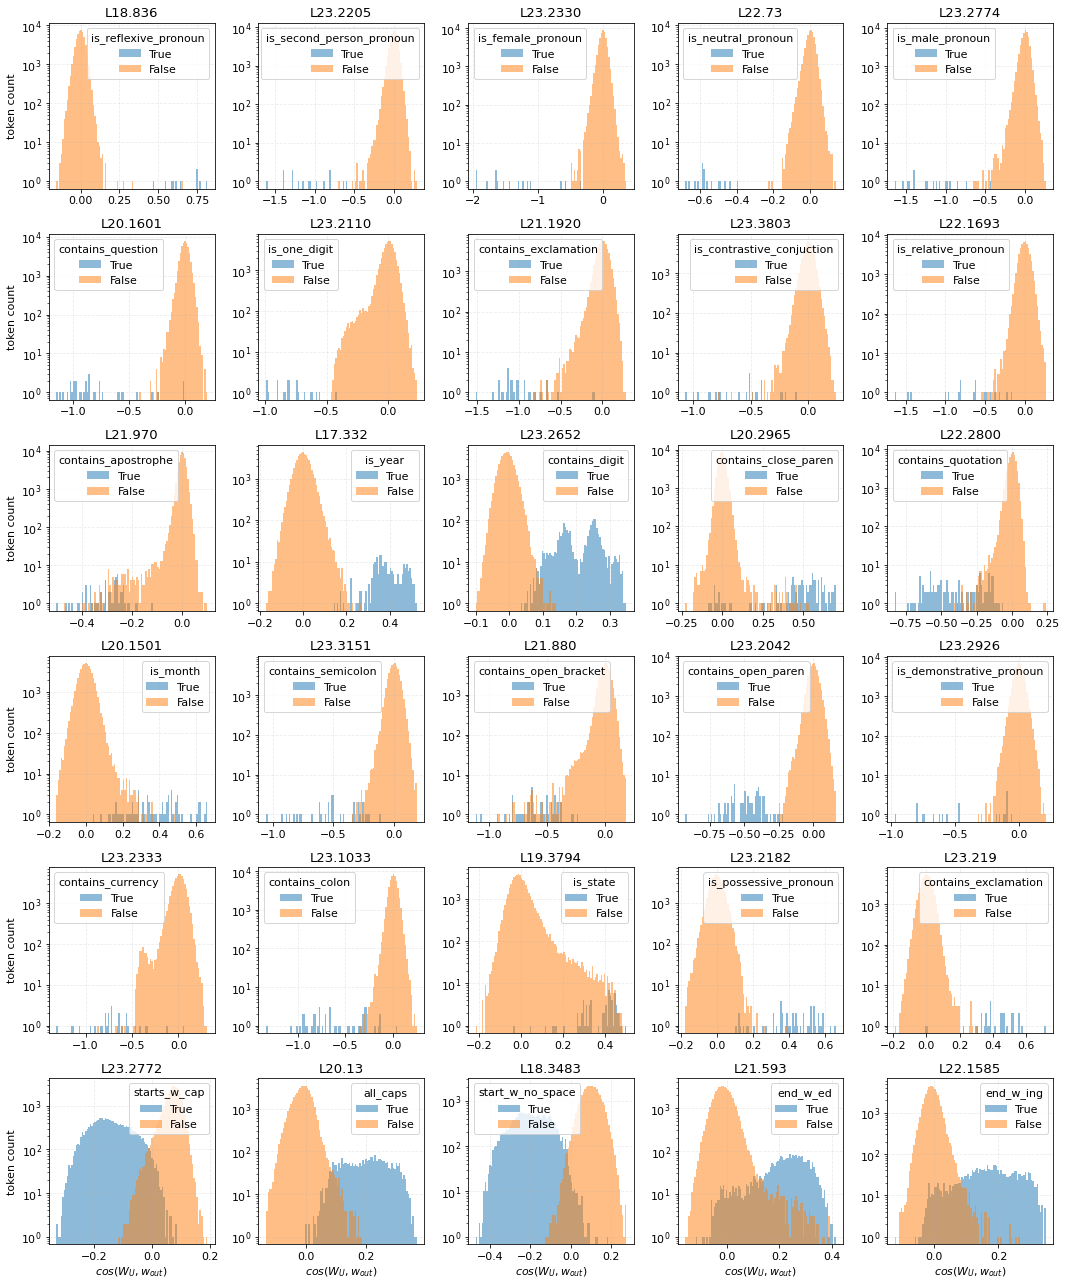

In [16]:
plot_prediction_neurons(top_pred_neurons, top_pred_neuron_class, {**high_kurtosis_composition_dict, **high_var_composition_dict}, vocab_df)
#plt.savefig('figures/prediction_neurons_appendix.png', bbox_inches='tight', dpi=75)

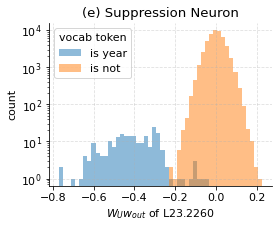

In [22]:
layer = 23
neuron_ix = 2260
class_label = 'is_year'

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
comp_scores = high_kurtosis_composition_dict[layer, neuron_ix]
bin_range = np.min(comp_scores), np.max(comp_scores)
ax.hist(comp_scores[vocab_df[class_label]], bins=50,
    log=True, range=bin_range, label='is year', alpha=0.5)
ax.hist(comp_scores[~vocab_df[class_label]], bins=50,
    log=True, range=bin_range, label='is not', alpha=0.5)
ax.set_title(f'(e) Suppression Neuron')

ax.set_ylabel('count')
ax.set_xlabel('$W_U w_{out}$ of L23.2260')

ax.spines['top'].set_visible(False)

ax.spines['right'].set_visible(False)

ax.grid(alpha=0.4, linestyle='--')

ax.legend(title='vocab token')

plt.savefig('figures/main_e_suppression.png', bbox_inches='tight', dpi=150)

(0.3, 23683.215612196258)

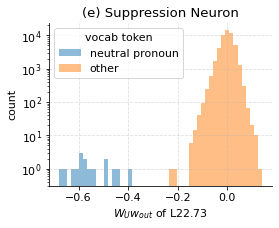

In [21]:
layer = 22
neuron_ix = 73
class_label = 'is_neutral_pronoun'

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
comp_scores = high_kurtosis_composition_dict[layer, neuron_ix]
bin_range = np.min(comp_scores), np.max(comp_scores)
ax.hist(comp_scores[vocab_df[class_label]], bins=50,
    log=True, range=bin_range, label='neutral pronoun', alpha=0.5)
ax.hist(comp_scores[~vocab_df[class_label]], bins=50,
    log=True, range=bin_range, label='other', alpha=0.5)
ax.set_title(f'(e) Suppression Neuron')

ax.set_ylabel('count')
ax.set_xlabel('$W_Uw_{out}$ of L22.73')

ax.spines['top'].set_visible(False)

ax.spines['right'].set_visible(False)

ax.grid(alpha=0.4, linestyle='--')

ax.legend(title='vocab token')
ax.set_ylim(bottom=0.3)

#plt.savefig('figures/main_e_suppression.png', bbox_inches='tight', dpi=150)

In [89]:
sub_df = vocab_df[['token_string', 'is_year', 'starts_w_space']]
sub_df['score'] = comp_scores

/tmp/ipykernel_30411/954306099.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['score'] = comp_scores


In [90]:
sub_df.query('is_year').sort_values('score', ascending=False).head(10)

,token_string,is_year,starts_w_space,score
33698,1500,True,False,-0.034627
39188,1800,True,False,-0.042799
36150,1600,True,False,-0.062243
20007,1500,True,True,-0.069339
26143,1600,True,True,-0.077850
35665,1700,True,True,-0.081368
48104,1900,True,False,-0.084170
21431,1800,True,True,-0.116689
38123,2100,True,True,-0.124187
40454,1920,True,False,-0.163612


In [87]:
sub_df.query('not is_year').sort_values('score', ascending=True).head(10)

,token_string,is_year,score
1129,19,False,-0.169419
1248,18,False,-0.160334
46550,ixties,False,-0.140568
1160,20,False,-0.140360
1596,17,False,-0.136850
1315,15,False,-0.133979
678,19,False,-0.128915
30418,millennials,False,-0.123839
10836,Vietnam,False,-0.119455
44471,twenties,False,-0.117705


In [115]:
model_name = 'stanford-gpt2-medium-a'
dataset_name = 'pile.test.all-10m.512'

ds = datasets.load_from_disk(f'token_datasets/gpt2/{dataset_name}')
ds_df = make_dataset_df(ds)


In [116]:
import copy

def get_plot_data(ds_df, W_out, W_U, model_name, dataset_name, feature):
    act_path = os.path.join('cached_activations', model_name, dataset_name)
    neuron_cols = []
    neuron_post_cols = []

    activation_df = copy.deepcopy(ds_df)

    neuron_ixs = []
    for l, n, f, p in PRED_NEURONS:
        if f == feature:
            acts = torch.load(os.path.join(act_path, f'{l}.{n}.pt'))
            col = f'{l}.{n}'
            neuron_ixs.append((l, n))
            activation_df[col] = acts.flatten().numpy().astype(np.float32)
            activation_df[col+'.post'] = gelu_fast(acts).flatten().numpy().astype(np.float32)
            neuron_cols.append(col)
            neuron_post_cols.append(col+'.post')

    feature_tokens = np.nonzero(vocab_df[feature].values)[0]
    activation_df['current_token_feature'] = np.isin(ds_df['current_token'], feature_tokens)
    activation_df['next_token_feature'] = np.isin(ds_df['next_token'], feature_tokens)

    neuron_cols = sorted(neuron_cols)
    neuron_post_cols = sorted(neuron_post_cols)

    neuron_list = [tuple(n.split('.')) for n in neuron_cols]
    W_out_neurons = np.stack([W_out[int(l), int(n), :] for l, n in neuron_list])

    is_feature_token = np.zeros(len(vocab_df), dtype=bool)
    is_feature_token[feature_tokens] = True
    logit_df = pd.concat([
        pd.DataFrame({
            'token': is_feature_token,
            'score': W_U @ W_out_neurons[ix],
            'neuron': [n for _ in range(len(is_feature_token))],
        })
    for ix, n in enumerate(neuron_cols)]) 

    return activation_df, logit_df, feature_tokens, neuron_cols, neuron_post_cols

In [92]:
# melt ds_df to have preactivations, postactivations, and neuron id as columns

activation_df, logit_df, feature_tokens, neuron_cols, neuron_post_cols = get_plot_data(
    ds_df, model_name, dataset_name, feature)

melted_activation_df = activation_df.melt(
    id_vars=['current_token', 'next_token', 'position', 'seq_ix', 'current_token_feature', 'next_token_feature'], 
    value_vars=neuron_cols, var_name='neuron', value_name='activation'
)

In [75]:
W_out = model.W_out.detach().cpu().numpy()
W_in = model.W_in.detach().cpu().numpy()
W_U = model.W_U.detach().cpu().numpy().T



In [99]:
neuron_list = [n.split('.') for n in neuron_cols]
W_out_neurons = np.stack([W_out[int(l), int(n), :] for l, n in neuron_list])
W_in_neurons = np.stack([W_in[int(l), :, int(n)] for l, n  in neuron_list])

is_feature_token = np.zeros(len(vocab_df), dtype=bool)
is_feature_token[feature_tokens] = True
dup_pred_df = pd.concat([
    pd.DataFrame({
        'token': is_feature_token,
        'score': W_U @ W_out_neurons[ix],
        'neuron': [n for _ in range(len(is_feature_token))],
    })
for ix, n in enumerate(neuron_list)]) 

In [122]:
# feature name, legend_labels
plot_data = [
    ('end_w_ing', ['ends with "ing"', 'does not']),
    ('is_neutral_pronoun', ['is neutral pronoun', 'is not']),
    ('is_second_person_pronoun', ['is 2nd person pronoun', 'is not']),
    ('all_caps', ['is all caps', 'is not']),
    ('contains_open_paren', ['contains open paren', 'does not']),
]

In [123]:
activation_df

,current_token,next_token,position,seq_ix,21.1131,21.1131.post,23.2042,23.2042.post,20.1561,20.1561.post,...,21.1325,21.1325.post,22.811,22.811.post,23.5,23.5.post,17.398,17.398.post,current_token_feature,next_token_feature
0,50256,20377,0,0,-0.614258,-0.165527,-1.617188,-0.085693,0.271484,0.164795,...,0.151978,0.085205,0.145752,0.081360,-1.414062,-0.111511,0.007492,0.003769,False,False
1,20377,13,1,0,-1.636719,-0.083130,-0.452637,-0.147461,-0.906738,-0.165405,...,-0.680664,-0.168945,-1.356445,-0.118896,-0.368652,-0.131348,-1.321289,-0.123230,False,False
2,13,679,2,0,-1.617188,-0.085693,-0.151611,-0.066650,-0.569824,-0.162109,...,-1.978516,-0.047333,-0.680664,-0.168945,0.150513,0.084290,-1.957031,-0.049225,False,False
3,679,41136,3,0,-1.632812,-0.083740,-0.941895,-0.163086,-0.205933,-0.086182,...,-0.710938,-0.169556,-1.677734,-0.078247,-0.683105,-0.169067,-2.044922,-0.041443,False,False
4,41136,9088,4,0,-1.752930,-0.069763,-0.910645,-0.165161,-0.786621,-0.169922,...,-0.020493,-0.010078,-1.110352,-0.148560,-0.667480,-0.168457,-2.244141,-0.027390,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10000379,11881,13,507,19531,-1.365234,-0.117981,0.030930,0.015839,-1.524414,-0.097534,...,0.192139,0.110718,-3.056641,-0.002985,-0.439697,-0.145142,-0.532715,-0.158325,False,False
10000380,13,775,508,19531,-1.680664,-0.078369,-1.219727,-0.135742,-0.699707,-0.169434,...,-1.688477,-0.077515,-1.504883,-0.099548,-0.417969,-0.141235,-1.944336,-0.050323,False,False
10000381,775,1064,509,19531,-2.503906,-0.014671,-1.829102,-0.061615,-0.622559,-0.166138,...,-0.568848,-0.161987,-1.229492,-0.134766,-0.606445,-0.164917,-1.859375,-0.058563,False,False
10000382,1064,326,510,19531,-1.627930,-0.084656,-0.978516,-0.160522,-0.422607,-0.142212,...,-0.036224,-0.017593,-1.191406,-0.139282,-0.692383,-0.169434,-2.363281,-0.020767,False,False


/tmp/ipykernel_41990/682401909.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/tmp/ipykernel_41990/682401909.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/tmp/ipykernel_41990/682401909.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/tmp/ipykernel_41990/682401909.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/tmp/ipykernel_41990/682401909.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of t

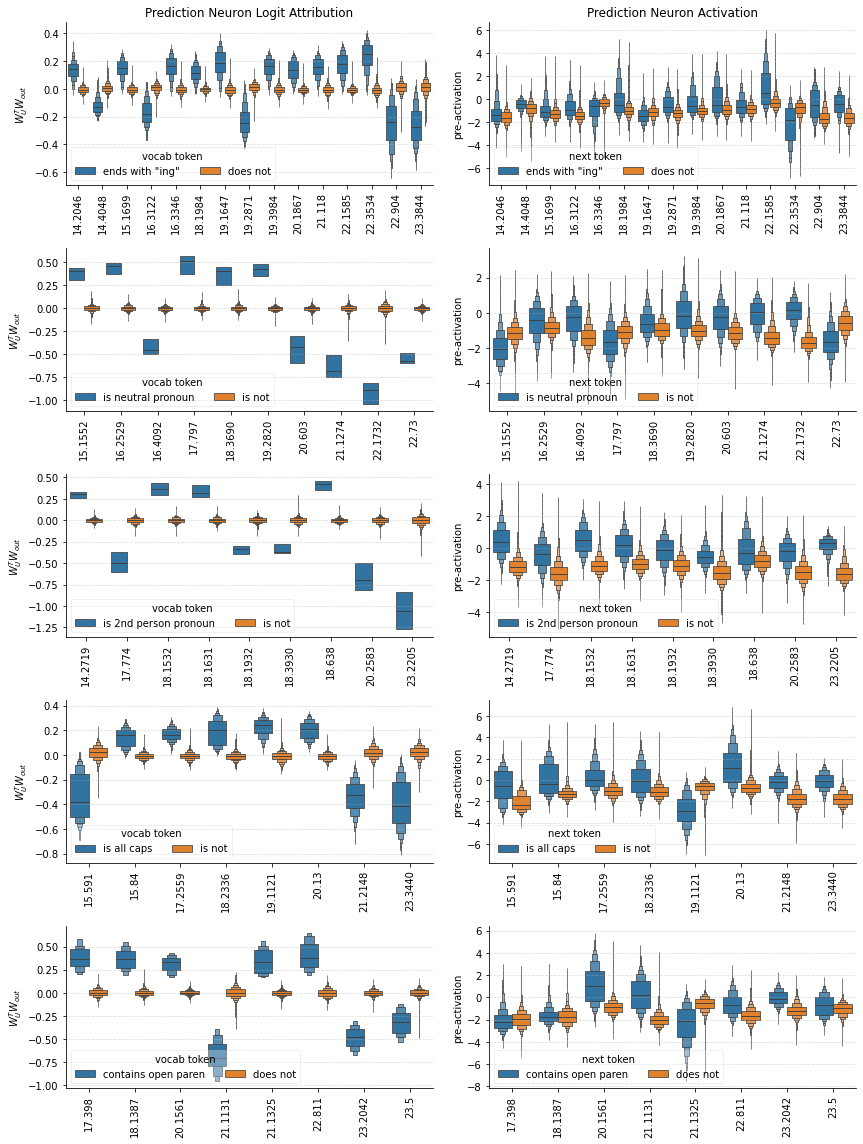

In [125]:
# set tick rotation to 90
fig, axs = plt.subplots(5, 2, figsize=(12, 16))


for row, (feature, legend_labels) in enumerate(plot_data):
    activation_df, logit_df, feature_tokens, neuron_cols, neuron_post_cols = get_plot_data(
        ds_df, W_out, W_U, model_name, dataset_name, feature)

    melted_activation_df = activation_df.melt(
        id_vars=['current_token', 'next_token', 'position', 'seq_ix', 'current_token_feature', 'next_token_feature'], 
        value_vars=neuron_cols, var_name='neuron', value_name='activation'
    )

    ax = axs[row, 0]
    sns.boxenplot(
        logit_df, x='neuron', y='score', hue='token', 
        hue_order=[True, False], order=neuron_cols, ax=ax, showfliers=False
    )
    ax.set_ylabel('$W_U^T W_{out}$')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.legend(title='vocab token', loc='lower left', ncols=2).get_frame().set_alpha(0.3)
    for ix, label in enumerate(legend_labels):
        ax.get_legend().get_texts()[ix].set_text(label)

    ax = axs[row, 1]
    sns.boxenplot(
        melted_activation_df, x='neuron', y='activation', hue='next_token_feature', 
        hue_order=[True, False], order=neuron_cols, ax=ax, showfliers=False
    )
    ax.set_ylabel('pre-activation')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.legend(title='next token', loc='lower left', ncols=2).get_frame().set_alpha(0.3)
    for ix, label in enumerate(legend_labels):
        ax.get_legend().get_texts()[ix].set_text(label)

for ax in axs.flatten():
    ax.grid(alpha=0.4, linestyle='--', axis='y')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('')

axs[0, 0].set_title('Prediction Neuron Logit Attribution')
axs[0, 1].set_title('Prediction Neuron Activation')

plt.tight_layout()

plt.savefig(f'figures/prediction_neuron_duplicates.png', bbox_inches='tight', dpi=75)

In [124]:
feature

'contains_open_paren'

In [127]:
W_out.shape

(24, 4096, 1024)

In [128]:
24 * 4096

98304

In [82]:
from sklearn.metrics.pairwise import cosine_similarity
W_in_cos = cosine_similarity(W_in_neurons)
W_out_cos = cosine_similarity(W_out_neurons)

<Axes: >

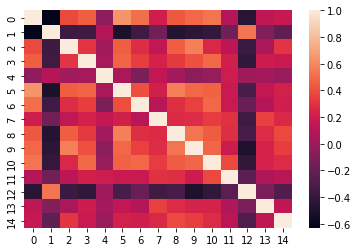

In [83]:
sns.heatmap(W_in_cos)

<Axes: >

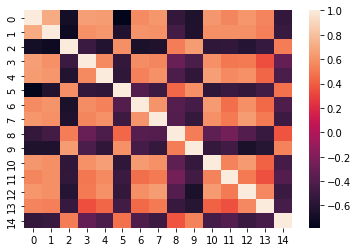

In [84]:
sns.heatmap(W_out_cos)

/tmp/ipykernel_41990/98929564.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/tmp/ipykernel_41990/98929564.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


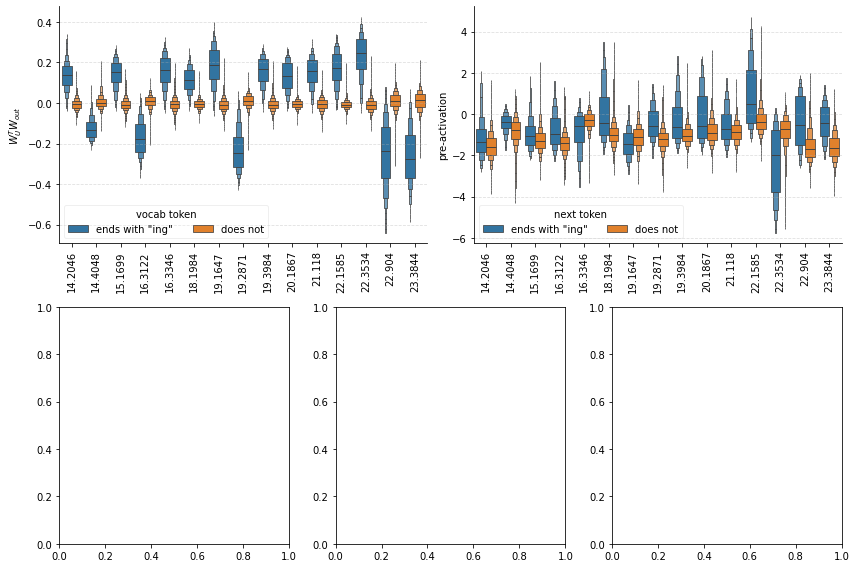

In [ ]:
# def clean_ax(ax):
#     ax.grid(alpha=0.4, linestyle='--', axis='y')
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     ax.set_xlabel('')

# import matplotlib.gridspec as gridspec

# fig = plt.figure(figsize=(12, 8))
# gs = gridspec.GridSpec(2, 6)


# class_labels = ['ends with "ing"', 'does not']

# ax = fig.add_subplot(gs[0, :3])
# sns.boxenplot(
#     dup_pred_df, x='neuron', y='score', hue='token', 
#     hue_order=[True, False], order=order, ax=ax, showfliers=False
# )
# ax.set_ylabel('$W_U^T W_{out}$')
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
# ax.legend(title='vocab token', loc='lower left', ncols=2).get_frame().set_alpha(0.3)
# for ix, label in enumerate(class_labels):
#     ax.get_legend().get_texts()[ix].set_text(label)
# clean_ax(ax)

# ax = fig.add_subplot(gs[0, 3:])

# sns.boxenplot(
#     preactivation_df.sample(500_000), x='neuron', y='activation', hue='next_token_feature', 
#     hue_order=[True, False], order=order, ax=ax, showfliers=False
# )
# ax.set_ylabel('pre-activation')
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
# ax.legend(title='next token', loc='lower left', ncols=2).get_frame().set_alpha(0.3)
# for ix, label in enumerate(class_labels):
#     ax.get_legend().get_texts()[ix].set_text(label)
# clean_ax(ax)

# ax = fig.add_subplot(gs[1, 0:2])


# ax = fig.add_subplot(gs[1, 2:4])


# ax = fig.add_subplot(gs[1, 4:6])

# plt.tight_layout()

In [30]:
pd.DataFrame(PRED_NEURONS, columns=['layer', 'neuron', 'class', 'token'])['class'].value_counts()

end_w_ing                     15
is_neutral_pronoun            10
is_second_person_pronoun       9
all_caps                       8
contains_colon                 8
is_demonstrative_pronoun       8
contains_open_paren            8
is_relative_pronoun            5
contains_digit                 5
contains_open_bracket          5
is_interrogative_pronoun       5
contains_close_paren           5
contains_question              5
is_male_pronoun                5
is_year                        5
starts_w_cap                   5
start_w_no_space_and_digit     4
contains_quotation             4
is_month                       4
is_possessive_pronoun          4
contains_semicolon             3
is_female_pronoun              3
is_state                       3
start_w_no_space               3
contains_exclamation           2
is_one_digit                   2
is_intensive_pronoun           1
Name: class, dtype: int64

# Basic Replication in Pythia

In [3]:
models = ['pythia-410m', 'pythia-1b', 'pythia-1.4b', 'pythia-2.8b', 'pythia-6.9b']

model_dfs = {model: load_neuron_df(model) for model in models}

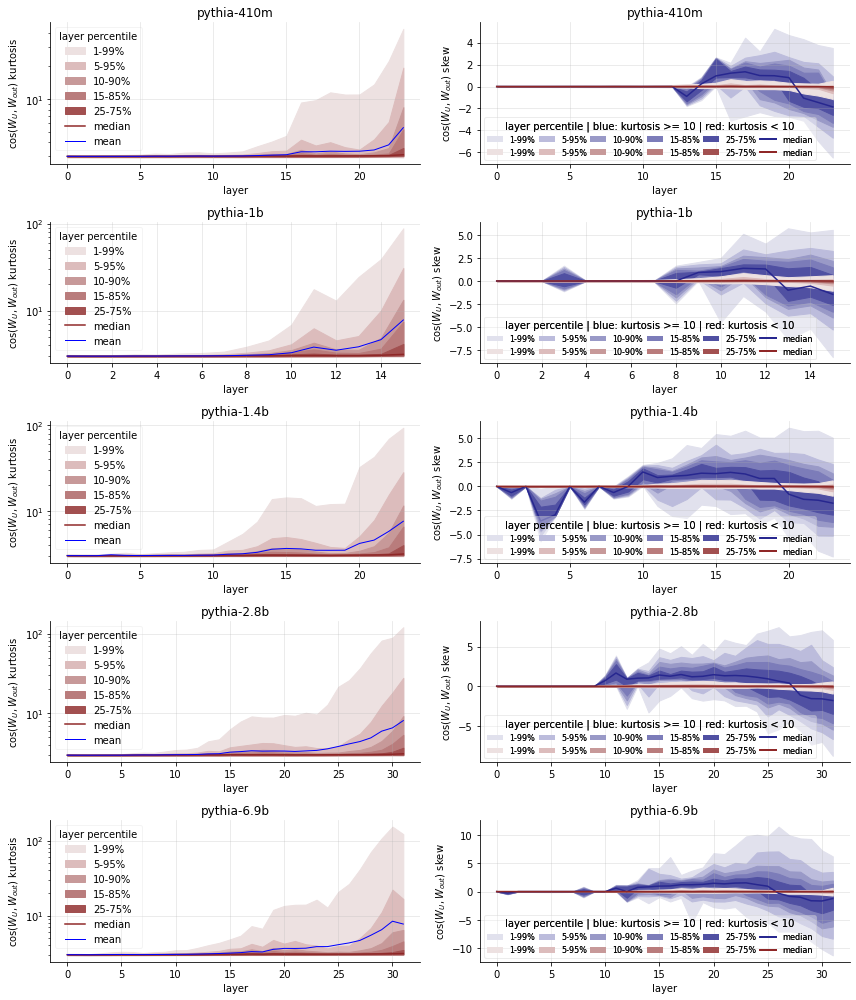

In [5]:
n = len(models)
fig, axs = plt.subplots(n, 2, figsize=(12, 2.8 * n))
for i, model in enumerate(models):
    neuron_df = model_dfs[model]
    plot_percentiles(neuron_df, col='vocab_kurt', ax=axs[i, 0])
    axs[i, 0].set_yscale('log')
    #plot_percentiles(neuron_df, col='vocab_skew', ax=axs[i, 1])
    plot_skew_low_kurt_ps_by_kurtosis(neuron_df, kurtosis_split=10, ax=axs[i, 1])

    for ax in axs[i]:
        ax.set_title(model)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.grid(alpha=0.3)

plt.tight_layout()

plt.savefig('figures/pythia_prediction_neurons.png', bbox_inches='tight')